# 毕业论文`GRAD`
## `MCIP`气象场分析

---
*@author: Evan*\
*@date: 2023-11-05*

In [1]:
import os
import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import rcParams
config = {
    "font.family":'Times New Roman',
    "mathtext.fontset":'stix',
    "font.serif": ['SimSun'],
}
rcParams.update(config)

import sys
sys.path.append('../../../src/')
from namelist import *
from mask import polygon_to_mask, average_data

# silence the warning note
import warnings
warnings.filterwarnings("ignore")

In [2]:
var = 'SFC_TMP'
month = "Sep"

low_years = np.array([2016,2015,2014])
high_years = np.array([2022,2021,2019])

low_files  = [os.path.join(processed_dir, f"{month}_{year}/{month}_{year}_mcip.nc") for year in low_years]
high_files = [os.path.join(processed_dir, f"{month}_{year}/{month}_{year}_mcip.nc") for year in high_years]

avg_low  = average_data(low_files, var)
avg_high = average_data(high_files, var)

lon = avg_low.longitude
lat = avg_low.latitude

In [6]:
cities = ['Guangzhou', 'Foshan', 'Dongguan', 'Shenzhen',
          'Zhongshan', 'Zhuhai', 'Zhaoqing', 'Jiangmen',
          'Huizhou']

df_low = {}
df_high = {}
for city in cities:
    shpvar = eval(f'shp_{city}_adm')
    shp = gpd.read_file(shpvar)

    mask    = polygon_to_mask(shp.geometry[0], lon, lat)
    mask_da = xr.DataArray(mask, dims=('y','x'))

    masked_low  = avg_low.where(mask_da)
    mean_low    = masked_low.mean(dim=('x','y'),skipna=True)
    masked_high = avg_high.where(mask_da)
    mean_high   = masked_high.mean(dim=('x','y'),skipna=True)

    df_low[city] = mean_low
    df_high[city] = mean_high
    print(f'Complete {city}')

Complete Guangzhou
Complete Foshan
Complete Dongguan
Complete Shenzhen
Complete Zhongshan
Complete Zhuhai
Complete Zhaoqing
Complete Jiangmen
Complete Huizhou


## 绘制热力图

查看各城市均值大小排序

In [27]:
df_city = pd.DataFrame(
    index=cities,
    data={'Low':[df_low[city].mean().values for city in cities],
          'High':[df_high[city].mean().values for city in cities]}
)

In [26]:
sorted_df = df_city.sort_values(by='Low',ascending=False)
sorted_df

,Low,High
Dongguan,29.06331,29.87426
Foshan,28.771338,29.500206
Zhongshan,28.611227,29.182047
Shenzhen,28.25825,28.892242
Zhuhai,27.883003,28.189976
Guangzhou,27.563244,28.363157
Jiangmen,27.196173,27.362293
Huizhou,26.397318,26.888529
Zhaoqing,26.219944,26.981884


In [28]:
sorted_df = df_city.sort_values(by='High',ascending=False)
sorted_df

,Low,High
Dongguan,29.06331,29.87426
Foshan,28.771338,29.500206
Zhongshan,28.611227,29.182047
Shenzhen,28.25825,28.892242
Guangzhou,27.563244,28.363157
Zhuhai,27.883003,28.189976
Jiangmen,27.196173,27.362293
Zhaoqing,26.219944,26.981884
Huizhou,26.397318,26.888529


In [112]:
# 排序1：按照high年气温从高到低
# city_list = ['Dongguan', 'Foshan', 'Zhongshan', 'Shenzhen',
#              'Guangzhou', 'Zhuhai', 'Jiangmen', 'Zhaoqing', 
#              'Huizhou']

# 排序2：按照纬度从北向南
city_list = ['Zhaoqing','Huizhou','Guangzhou','Foshan',
             'Dongguan','Shenzhen','Zhongshan','Jiangmen',
             'Zhuhai']

# 排序3：按照经度从西向东
# city_list = ['Zhaoqing','Jiangmen','Foshan','Zhuhai',
#              'Zhongshan','Guangzhou','Dongguan','Shenzhen',
#              'Huizhou']

thermal_low = np.array(
 np.array([df_low[city].resample(time='D').mean() for city in city_list])
)
thermal_high = np.array(
 np.array([df_high[city].resample(time='D').mean() for city in city_list])
)
thermal_low.shape

(9, 30)

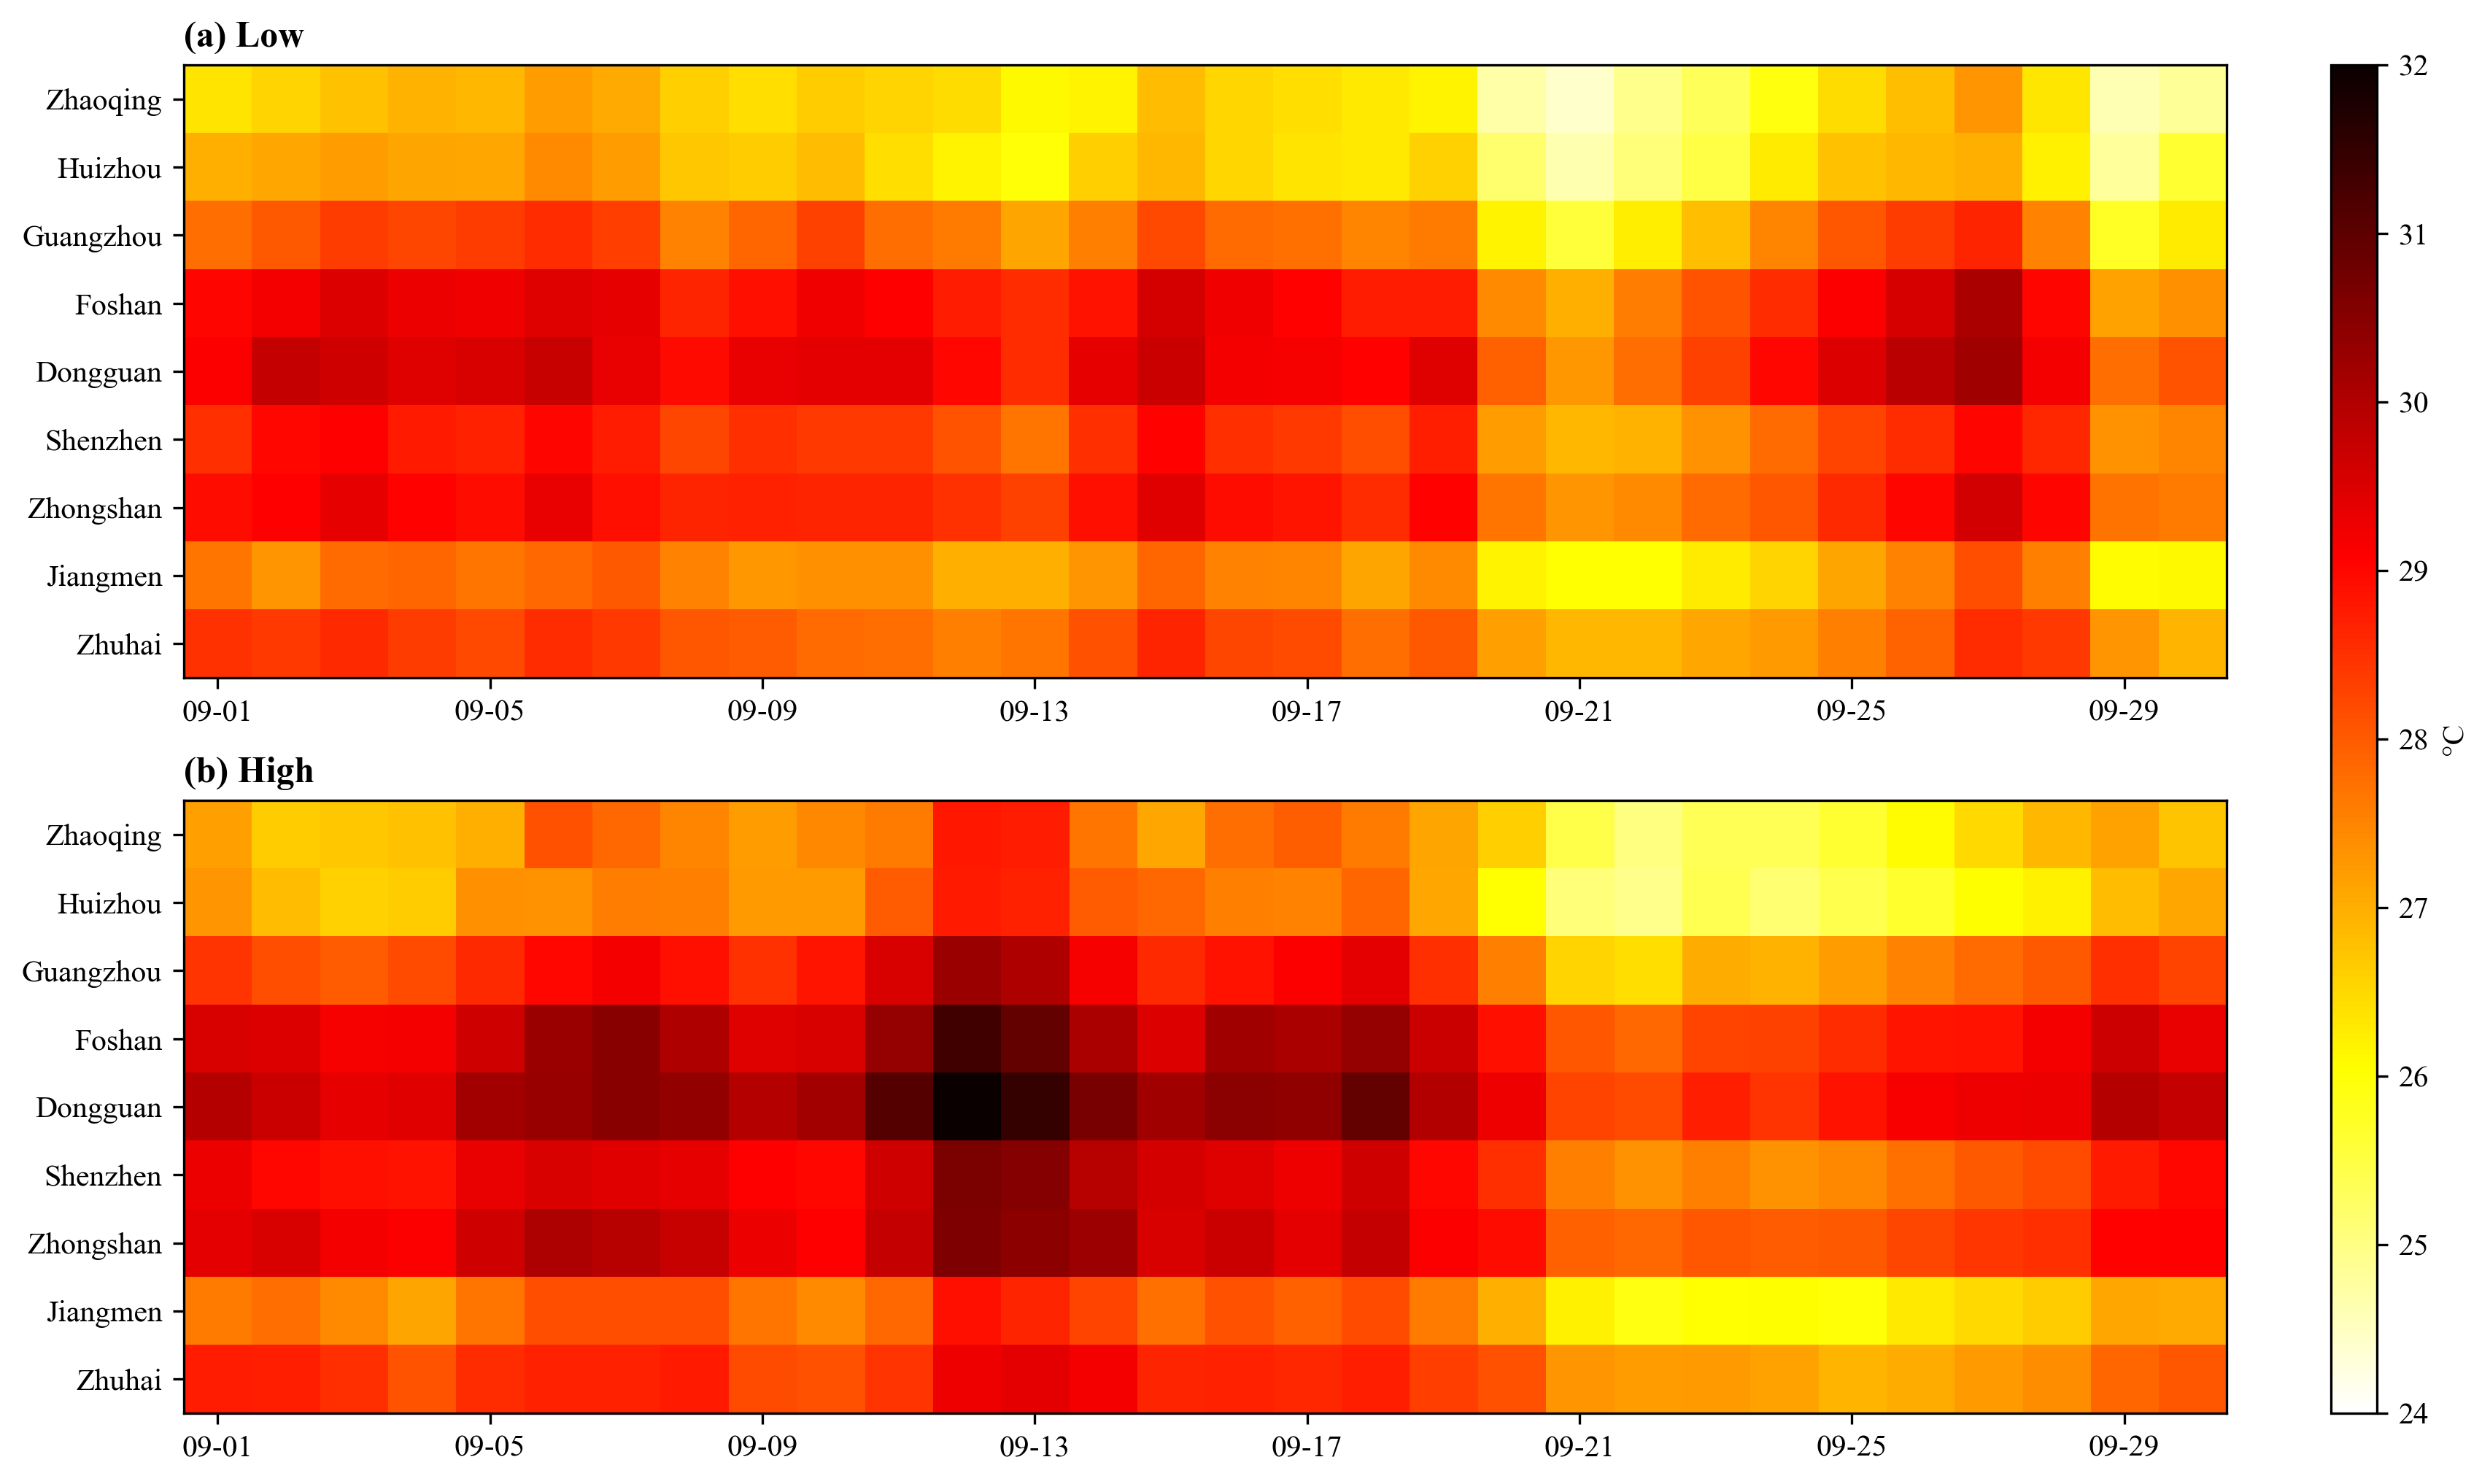

In [113]:
cmin = 24
cmax = 32

fig = plt.figure(figsize=(14, 8),dpi=300)
ax = fig.subplots(2,1)

ci = ax[0].imshow(thermal_low, vmin=cmin,vmax=cmax,cmap='hot_r')
ci = ax[1].imshow(thermal_high, vmin=cmin,vmax=cmax,cmap='hot_r')

ax[0].set_title('(a) Low', loc='left',fontdict={'fontsize':12,'fontweight':'bold'})
ax[1].set_title('(b) High', loc='left',fontdict={'fontsize':12,'fontweight':'bold'})

for ax in ax.flat:
    ax.set_xticks(np.arange(0,np.size(thermal_high,1),4))
    ax.set_xticklabels(pd.date_range('2023-09-01', '2023-09-30', freq='4D').strftime('%m-%d'))
    ax.set_yticks(np.arange(len(city_list)))
    ax.set_yticklabels(city_list)

fig.subplots_adjust(right=0.9,hspace=0.2)
position = fig.add_axes([0.88, 0.11, 0.015, 0.77])
cbar = fig.colorbar(ci, cax=position)
cbar.set_ticks(np.arange(cmin,cmax+.1,1))
cbar.set_label('°C')
plt.show()


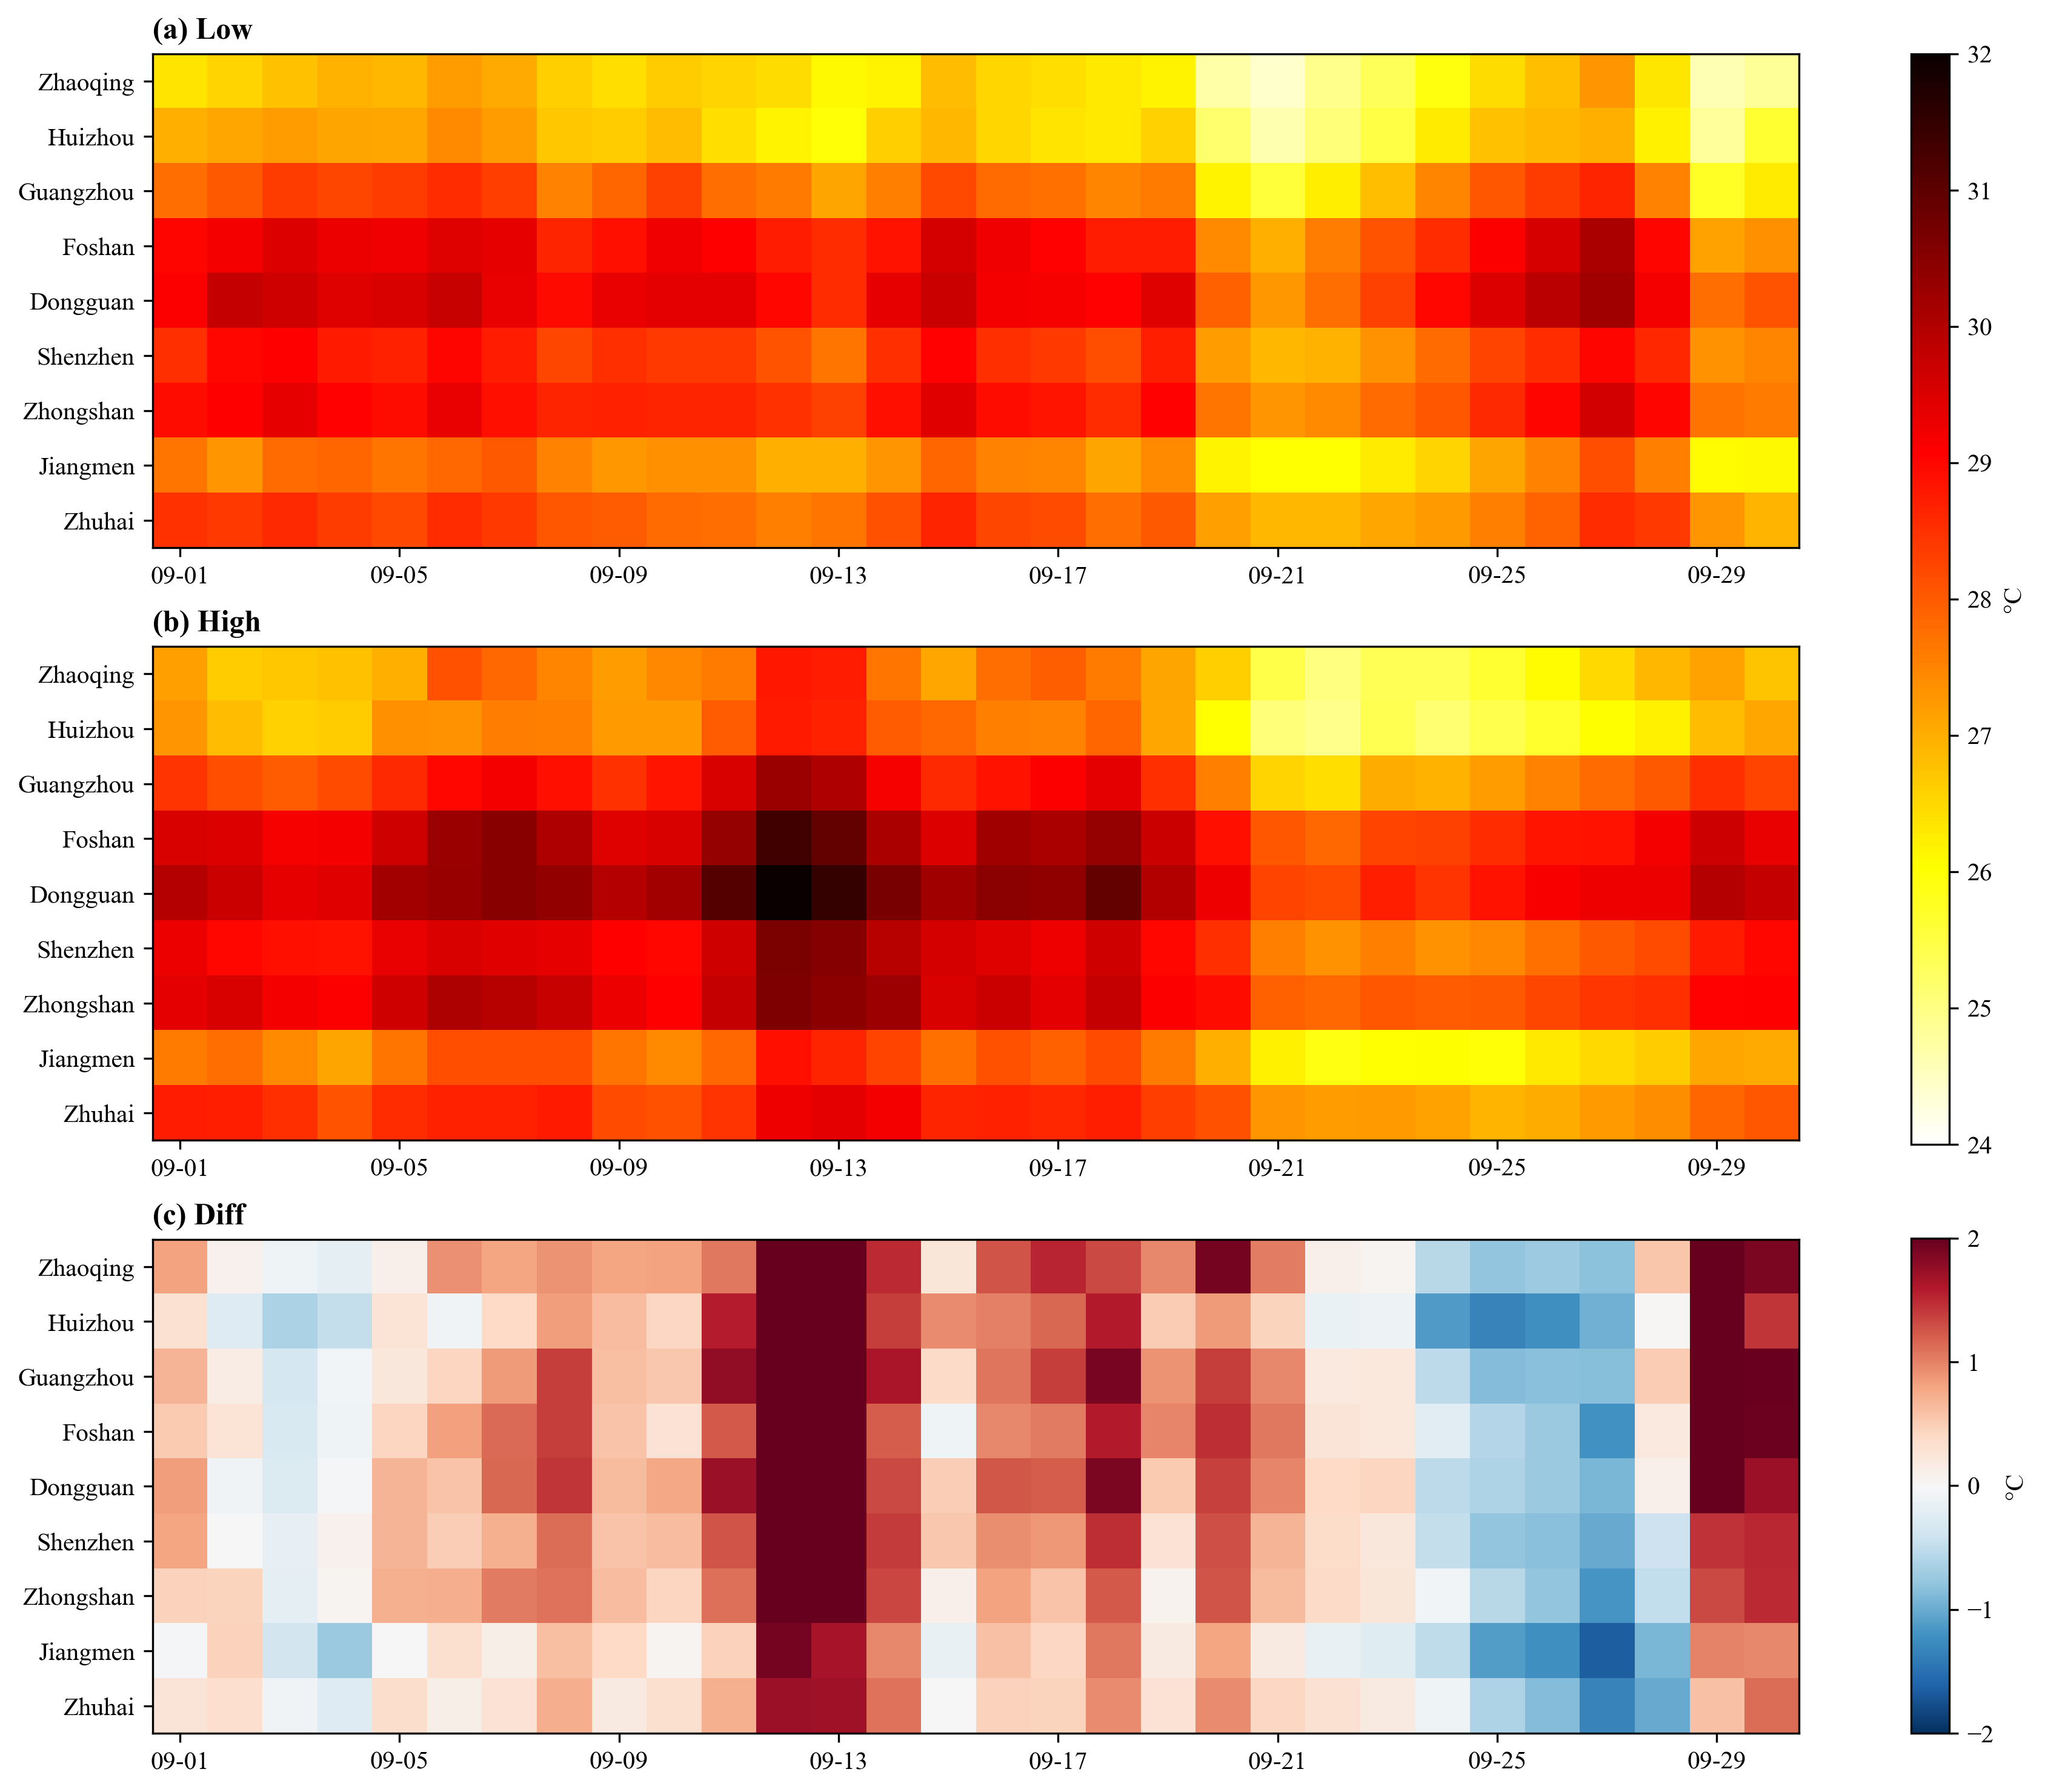

In [116]:
cmin = 24
cmax = 32
dmin = -2
dmax = 2

fig = plt.figure(figsize=(14, 12),dpi=300)
ax = fig.subplots(3,1)

ci = ax[0].imshow(thermal_low, vmin=cmin,vmax=cmax,cmap='hot_r')
ci = ax[1].imshow(thermal_high, vmin=cmin,vmax=cmax,cmap='hot_r')
cd = ax[2].imshow(thermal_high-thermal_low, vmin=dmin,vmax=dmax,cmap='RdBu_r')

ax[0].set_title('(a) Low', loc='left',fontdict={'fontsize':12,'fontweight':'bold'})
ax[1].set_title('(b) High', loc='left',fontdict={'fontsize':12,'fontweight':'bold'})
ax[2].set_title('(c) Diff', loc='left',fontdict={'fontsize':12,'fontweight':'bold'})

for i in range(3):
    ax[i].set_xticks(np.arange(0,np.size(thermal_high,1),4))
    ax[i].set_xticklabels(pd.date_range('2023-09-01', '2023-09-30', freq='4D').strftime('%m-%d'))
    ax[i].set_yticks(np.arange(len(city_list)))
    ax[i].set_yticklabels(city_list)

fig.subplots_adjust(right=0.9,hspace=0.2)

position1 = fig.add_axes([0.88, 0.38, 0.015, 0.5])
cbar1 = fig.colorbar(ci, cax=position1)
cbar1.set_ticks(np.arange(cmin,cmax+.1,1))
cbar1.set_label('°C')

position2 = fig.add_axes([0.88, 0.11, 0.015, 0.227])
cbar2 = fig.colorbar(cd, cax=position2)
cbar2.set_ticks(np.arange(dmin,dmax+.1,1))
cbar2.set_label('°C')
plt.show()
